<a href="https://colab.research.google.com/github/blueriver212/CatAnalysis/blob/main/OrbitCallibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [259]:
import sp3
from astropy.coordinates import GCRS, ITRS, SkyCoord, TEME
from astropy import units
from astropy.time import Time
import numpy as np
np.set_printoptions(precision=15, suppress=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sgp4.api import Satrec, jday
from datetime import datetime
from sgp4.earth_gravity import wgs84
import json
from datetime import datetime, timedelta
from dateutil.tz import tzutc
from Utilities import utc_to_jd 
import os
import pickle

Start date: 2023-01-05 21:59:42+00:00
End date: 2023-01-06 12:00:12+00:00
Number of tles available in the time range:  11


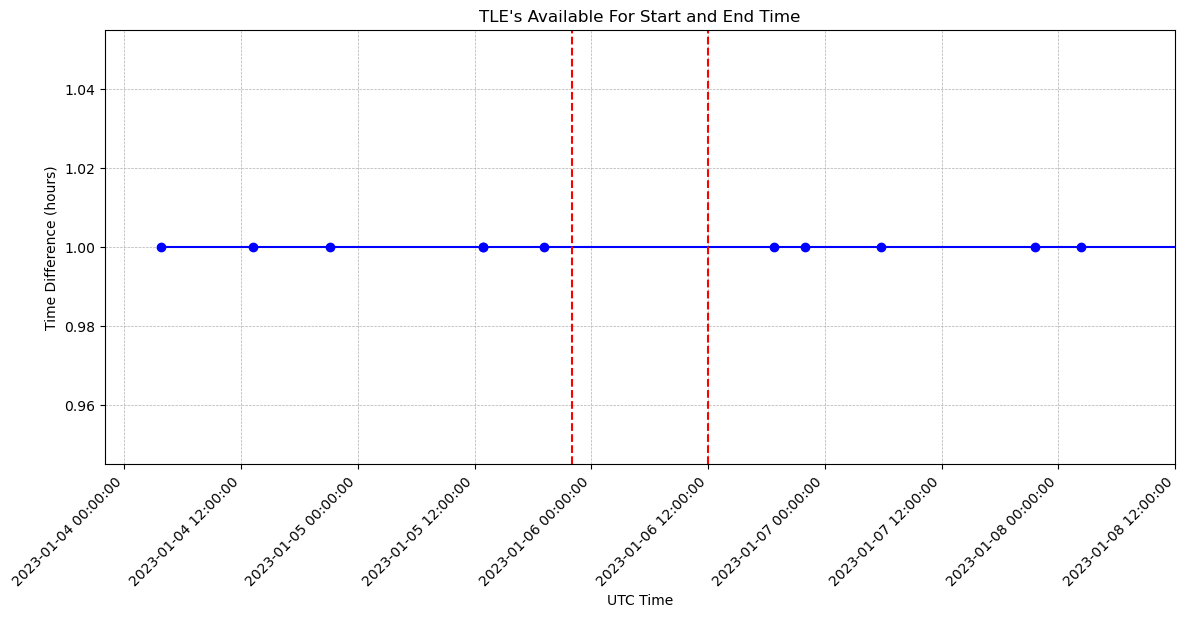

In [260]:
# chose the files that you want to use
RawDataFolder = 'v4'
data_format = 'sp3'

# load the sp3 file
if data_format == 'sp3':
    product = sp3.Product.from_file(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'GFZOP_RSO_L64_G_20230105_220000_20230106_120000_v02.sp3'))

if data_format == 'pickle':
    # open the pickle file
    with open(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'L64_sp3_data.pkl'), 'rb') as file:
        product = pickle.load(file)

# Create some buffer to ensure a TLE capture the entire timeframe
start_time = product.satellites[0].records[0].time
end_time = product.satellites[0].records[-1].time
start_time_range = start_time - timedelta(days=2)
end_time_range = end_time + timedelta(days=2)
print('Start date: {}'.format(start_time))
print('End date: {}'.format(end_time))

with open(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'grace-fo-1-tle-43476.json'), "r") as file:
    tle_raw_l64 = json.load(file)

tles = [entry for entry in tle_raw_l64 if start_time_range <= datetime.fromisoformat(entry['EPOCH']).replace(tzinfo=tzutc()) <= end_time_range]

print("Number of tles available in the time range: ", len(tles))

## PLOT THE SPREAD OF TLEs BETWEEEN THE TIME RANGES
epoch_times = [datetime.fromisoformat(entry['EPOCH']) for entry in tle_raw_l64]
time_diffs = [1 for _ in epoch_times] # in hours

# Plot
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, time_diffs, marker='o', linestyle='-', color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # for slanting date labels
plt.title("TLE's Available For Start and End Time")
plt.xlabel("UTC Time")
plt.ylabel("Time Difference (hours)")
plt.axvline(start_time, color='red', linestyle='--', label='Start Time')
plt.axvline(end_time, color='red', linestyle='--', label='End Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlim(start_time_range, end_time_range)
plt.show()

In [261]:
if data_format == 'sp3':
    sp3_time = [result.time for result in product.satellites[0].records]
if data_format == 'pickle':
    sp3_time = [result.time for result in product]

from datetime import timedelta
from astropy.utils import iers
iers.conf.auto_download = True  

# this takes less than 1 lol
def process_raw_sp3_vectorized(product):
    # Extract positions and velocities
    positions = np.array([record.position for record in product.satellites[0].records])
    velocities = np.array([record.velocity for record in product.satellites[0].records])

    # Convert positions and velocities to Astropy Quantity objects
    positions = positions * units.meter
    velocities = velocities * units.meter / units.second

    # Convert times and adjust for leap seconds
    times = Time([record.time for record in product.satellites[0].records]) - timedelta(seconds=18)

    # Perform the transformation in a vectorized manner
    itrs = ITRS(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2], 
                v_x=velocities[:, 0], v_y=velocities[:, 1], v_z=velocities[:, 2], 
                representation_type='cartesian', differential_type='cartesian', obstime=times)
    gcrs = itrs.transform_to(GCRS(obstime=times))

    # Extract transformed positions and velocities
    transformed_positions = np.vstack([gcrs.cartesian.x.value, gcrs.cartesian.y.value, gcrs.cartesian.z.value]).T
    transformed_velocities = np.vstack([gcrs.velocity.d_x.value * 1000, gcrs.velocity.d_y.value * 1000, gcrs.velocity.d_z.value * 1000]).T

    # Construct the ephemeris dictionary
    sp3_ephemeris = [{'time': time, 'position': pos, 'velocity': vel} 
                     for time, pos, vel in zip(times, transformed_positions, transformed_velocities)]

    return sp3_ephemeris

sp3_ephemeris = process_raw_sp3_vectorized(product)

### Time plot of data

In [262]:
# dump the sp3_ephemeris to a pickle file
if data_format == 'pickle':
    # save the pickle file as it is usually massive
    with open(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'sp3_ephemeris.pkl'), 'wb') as file:
        pickle.dump(sp3_ephemeris, file)

In [263]:
import plotly.graph_objects as go

# Your existing data for sp3_ephemeris_L64
x_L64 = [entry['position'][0] for entry in sp3_ephemeris]
y_L64 = [entry['position'][1] for entry in sp3_ephemeris]
z_L64 = [entry['position'][2] for entry in sp3_ephemeris]

# Extracting data for sp3_ephemeris_L65
x_L65 = [entry['position'][0] for entry in sp3_ephemeris]
y_L65 = [entry['position'][1] for entry in sp3_ephemeris]
z_L65 = [entry['position'][2] for entry in sp3_ephemeris]

# Create a Plotly figure
fig = go.Figure()

# Adding trace for sp3_ephemeris_L64
fig.add_trace(go.Scatter3d(x=x_L64, y=y_L64, z=z_L64, mode='markers',
                           marker=dict(size=4, color='blue'),
                           name='Satellite L64'))

# Adding trace for sp3_ephemeris_L65
fig.add_trace(go.Scatter3d(x=x_L65, y=y_L65, z=z_L65, mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Satellite L65'))

# Updating layout
fig.update_layout(
    title='3D Plot of SP3 Ephemeris Position for Two Satellites',
    scene=dict(
        xaxis_title='X Position (km)',
        yaxis_title='Y Position (km)',
        zaxis_title='Z Position (km)'
    ),
    legend_title='Satellites'
)

fig.show()


In [264]:
from datetime import datetime, timedelta, timezone
import numpy as np
from astropy.time import Time
from astropy.coordinates import GCRS, ITRS
from astropy import units

def utc_to_jd(time_stamps):
    """
    Convert UTC datetime or string representations to Julian Date (JD).

    This function takes in either a single datetime, string representation of a datetime, or a list of them. It then
    converts each of these into its corresponding Julian Date (JD) value. If a list is provided, it returns a list of JD
    values. If a single datetime or string is provided, it returns a single JD value.

    :param time_stamps: The datetime object(s) or string representation(s) of dates/times to be converted to Julian Date.
                        Strings should be in the format '%Y-%m-%d' or '%Y-%m-%d %H:%M:%S'.
    :type time_stamps: datetime.datetime, str or list of datetime.datetime/str
    :return: The corresponding Julian Date (JD) value(s) for the provided datetime(s) or string representation(s).
             Returns a single float if the input is a single datetime or string, and a list of floats if the input is a list.
    :rtype: float or list of float

    .. note:: The function uses the 'astropy' library for the conversion, so ensure that 'astropy' is installed and available.
    """
    if not isinstance(time_stamps, list):
        time_stamps = [time_stamps]

    UTC_string = []
    for ts in time_stamps:
        try:
            UTC_string.append(ts.strftime('%Y-%m-%d %H:%M:%S'))
        except:
            time_str = datetime.datetime.strptime(ts, '%Y-%m-%d')
            UTC_string.append(time_str.strftime('%Y-%m-%d %H:%M:%S'))

    t = Time(UTC_string, format='iso', scale='utc')  # astropy time object
    jd = t.to_value('jd', 'long')  # convert to jd

    jd_vals = [float(j) for j in jd]

    # If the input was a single datetime, then return a single value. Otherwise, return the list.
    return jd_vals[0] if len(jd_vals) == 1 else jd_vals

In [265]:
# # Propagate using the most up to date TLE, here the time is to go backwards through the tle list
from datetime import datetime, timedelta
def tle_propagate_using_sp3_time(input_tles, sp3_time):
    tle_ephemeris = []
    for _sp3_time in sp3_time:
        most_recent_tle = None
        for tle in reversed(input_tles):
            tle_time = datetime.strptime(tle['EPOCH'], '%Y-%m-%d %H:%M:%S').replace(tzinfo=tzutc())
            if tle_time <= _sp3_time:
                most_recent_tle = tle
                break

        if not most_recent_tle:
            # Handle case where no valid TLE is found for _sp3_time
            continue

        # Propagate using SGP4 for that specific timestep with the found TLE:
        satellite = Satrec.twoline2rv(most_recent_tle['TLE_LINE1'], most_recent_tle['TLE_LINE2'])
        jd, fr = jday(_sp3_time.year, _sp3_time.month, _sp3_time.day, _sp3_time.hour, _sp3_time.minute, _sp3_time.second)
        e, r, v = satellite.sgp4(jd, fr)

        x,y,z= r[0], r[1], r[2]
        u,v,w= v[0], v[1], v[2]

        # tle data is in the TEME frame, this will need to be converted to J2000
        time = utc_to_jd(_sp3_time)
        astropy_time = Time(time, format="jd")
        #astropy_time = Time(_sp3_time)

        # convert to astropy skycoord object
        skycoord = SkyCoord(x, y, z, unit='km', representation_type='cartesian', frame=TEME(obstime=astropy_time))

        # convert to GCRS frame
        gcrs = skycoord.transform_to(GCRS(obstime=astropy_time))

        # convert to cartesian coordinates
        x, y, z = gcrs.cartesian.xyz.to(units.m)

        # convert to astropy skycoord object
        skycoord = SkyCoord(u, v, w, unit='km/s', representation_type='cartesian', frame=TEME(obstime=astropy_time))

        # convert to GCRS frame
        gcrs = skycoord.transform_to(GCRS(obstime=astropy_time))

        # convert to cartesian coordinates
        u, v, w = gcrs.cartesian.xyz.to(units.m/units.s)

        # Store the result in the ephemeris list:
        tle_ephemeris.append({
            'time': _sp3_time,
            'position': np.array([x.value, y.value, z.value]),
            'velocity': np.array([u.value, v.value, w.value]),
        })
    return tle_ephemeris


tle_ephemeris = tle_propagate_using_sp3_time(tles, sp3_time)

## HCL Differences

In [266]:
import matplotlib.pyplot as plt

def plot_HCL(time, H_diffs, C_diffs, L_diffs):
    # Plotting H_diffs vs time
    plt.figure(figsize=(10, 6))
    plt.plot(time, H_diffs, color='red', label='H_diffs')
    plt.xlabel('Time')
    plt.ylabel('H_diffs')
    plt.title('H_diffs vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting C_diffs vs time
    plt.figure(figsize=(10, 6))
    plt.plot(time, C_diffs, color='blue', label='C_diffs')
    plt.xlabel('Time')
    plt.ylabel('C_diffs')
    plt.title('C_diffs vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting L_diffs vs time
    plt.figure(figsize=(10, 6))
    plt.plot(time, L_diffs, color='green', label='L_diffs')
    plt.xlabel('Time')
    plt.ylabel('L_diffs')
    plt.title('L_diffs vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

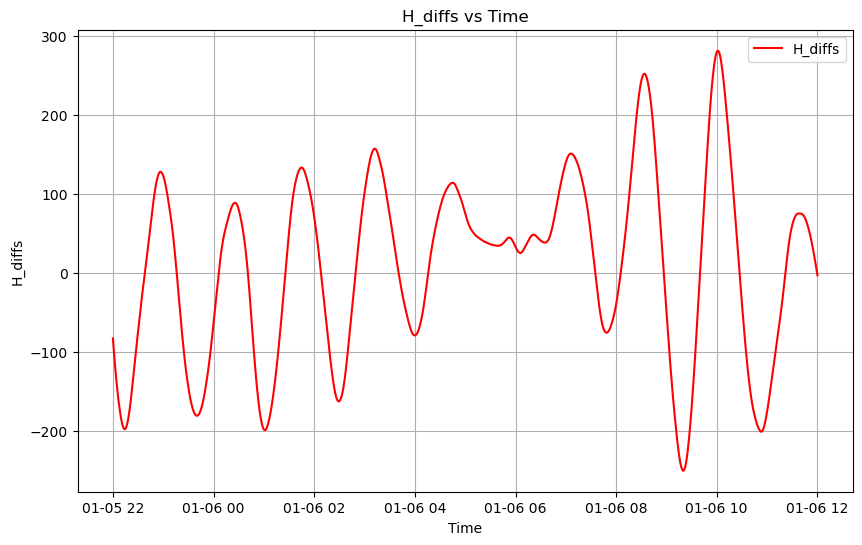

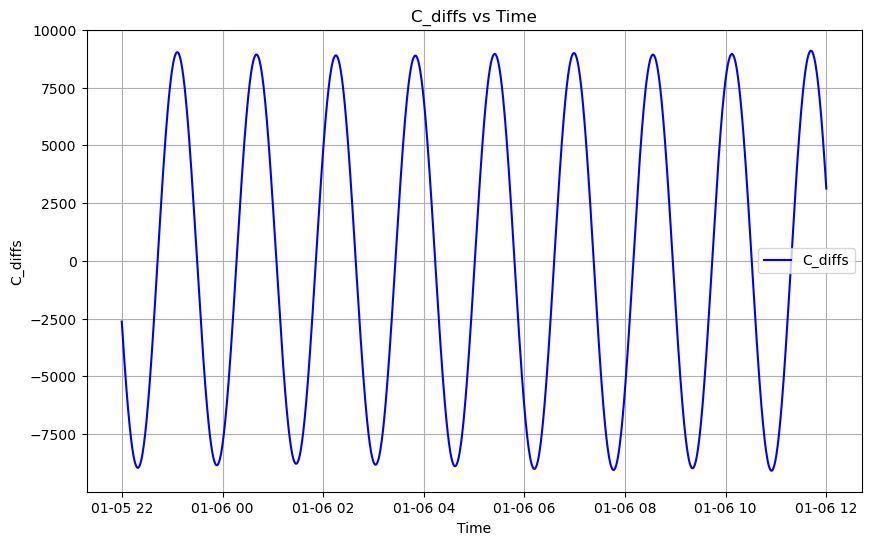

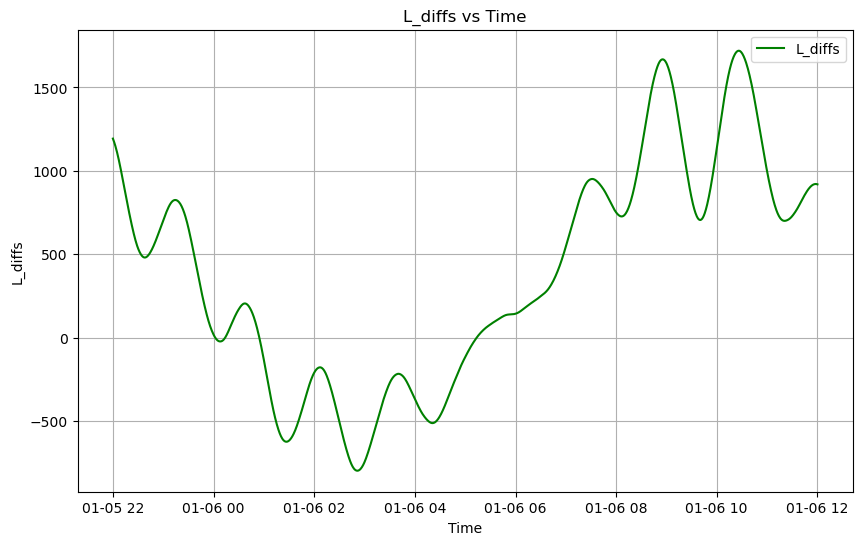

In [267]:
def HCL_diff(eph1, eph2):
    H_diffs = []
    C_diffs = []
    L_diffs = []
    time = []
    positions = []
    xyz_correction = []
    velocity = []

    for i in range(0, len(eph1), 1):
        
        # charles 2023
        r1 = np.array(eph1[i]['position'])
        r2 = np.array(eph2[i]['position'])

        v1 = np.array(eph1[i]['velocity'])
        v2 = np.array(eph2[i]['velocity'])

        unit_radial = r1/np.linalg.norm(r1)
        unit_cross_track = np.cross(r1, v1)/np.linalg.norm(np.cross(r1, v1))
        unit_along_track = np.cross(unit_radial, unit_cross_track)

        #put the three unit vectors into a matrix
        unit_vectors = np.array([unit_radial, unit_cross_track, unit_along_track])

        #subtract the two position vectors
        r_diff = r1 - r2

        #relative position in HCL frame
        r_diff_HCL = np.matmul(unit_vectors, r_diff)

        #height, cross track and along track differences
        h_diff = r_diff_HCL[0]
        c_diff = r_diff_HCL[1]
        l_diff = r_diff_HCL[2]

        H_diffs.append(h_diff)
        C_diffs.append(c_diff)
        L_diffs.append(l_diff)
        time.append(eph1[i]['time'])
        positions.append(r1)
        xyz_correction.append(r_diff)
        velocity.append(v1)
        

    return [time, H_diffs, C_diffs, L_diffs, positions, velocity, xyz_correction] # also return the position and velocity of the TLE ephemeris for the correction mapping

grace1_ephemeris = HCL_diff(tle_ephemeris, sp3_ephemeris)

plot_HCL(grace1_ephemeris[0], grace1_ephemeris[1], grace1_ephemeris[2], grace1_ephemeris[3])

In [268]:
# Calculate altitudes and extract times
tle_times = [entry['time'] for entry in tle_ephemeris]
tle_altitudes = [np.linalg.norm(entry['position']) for entry in tle_ephemeris]
sp3_altitude = [np.linalg.norm(entry['position']) for entry in sp3_ephemeris]

# Plot
import plotly.graph_objects as go


# Create the scatter plot
fig = go.Figure()

# Add SP3 altitude data
fig.add_trace(go.Scatter(x=sp3_time, y=sp3_altitude, mode='lines+markers',
                         name='SP3 Altitude', line=dict(color='blue')))

# Add TLE altitude data
fig.add_trace(go.Scatter(x=tle_times, y=tle_altitudes, mode='lines+markers',
                         name='TLE Altitude', line=dict(color='red')))

# Add vertical lines for start_time and end_time
fig.add_shape(
    go.layout.Shape(type="line", x0=start_time, x1=start_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="Start Time")
)
fig.add_shape(
    go.layout.Shape(type="line", x0=end_time, x1=end_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="End Time")
)

# Setting labels, title and layout
fig.update_layout(title='Altitude over Time',
                  xaxis_title='Time',
                  yaxis_title='Altitude (m)',
                  xaxis=dict(showgrid=True, showline=True, showticklabels=True, tickangle=45),
                  yaxis=dict(showgrid=True, showline=True, showticklabels=True),
                  showlegend=True)

# Show the interactive plot
fig.show()

In [269]:
import plotly.graph_objects as go

# Your SP3 Ephemeris positions
x_sp3 = [entry['position'][0] for entry in sp3_ephemeris]
y_sp3 = [entry['position'][1] for entry in sp3_ephemeris]
z_sp3 = [entry['position'][2] for entry in sp3_ephemeris]

# Assuming you have another dataset named tle_ephemeris
x_tle = [entry['position'][0] for entry in tle_ephemeris]
y_tle = [entry['position'][1] for entry in tle_ephemeris]
z_tle = [entry['position'][2] for entry in tle_ephemeris]

# Create the plot
fig = go.Figure()

# Add SP3 Ephemeris data
fig.add_trace(go.Scatter3d(x=x_sp3, y=y_sp3, z=z_sp3, mode='markers',
                           marker=dict(size=5, color='blue', opacity=0.5), name='SP3 Ephemeris'))

# Add TLE Ephemeris data
fig.add_trace(go.Scatter3d(x=x_tle, y=y_tle, z=z_tle, mode='markers',
                           marker=dict(size=5, color='red', opacity=0.5), name='TLE Ephemeris'))

# Setting labels and title
fig.update_layout(scene=dict(xaxis_title='X Position (km)',
                             yaxis_title='Y Position (km)',
                             zaxis_title='Z Position (km)'),
                  title='3D Scatter plot of SP3 and TLE Ephemeris Positions')

# Show the interactive plot
fig.show()


# Mapping the Errors

Now we to map the errors between the sp3 data of the spacecraft to the TLE. 

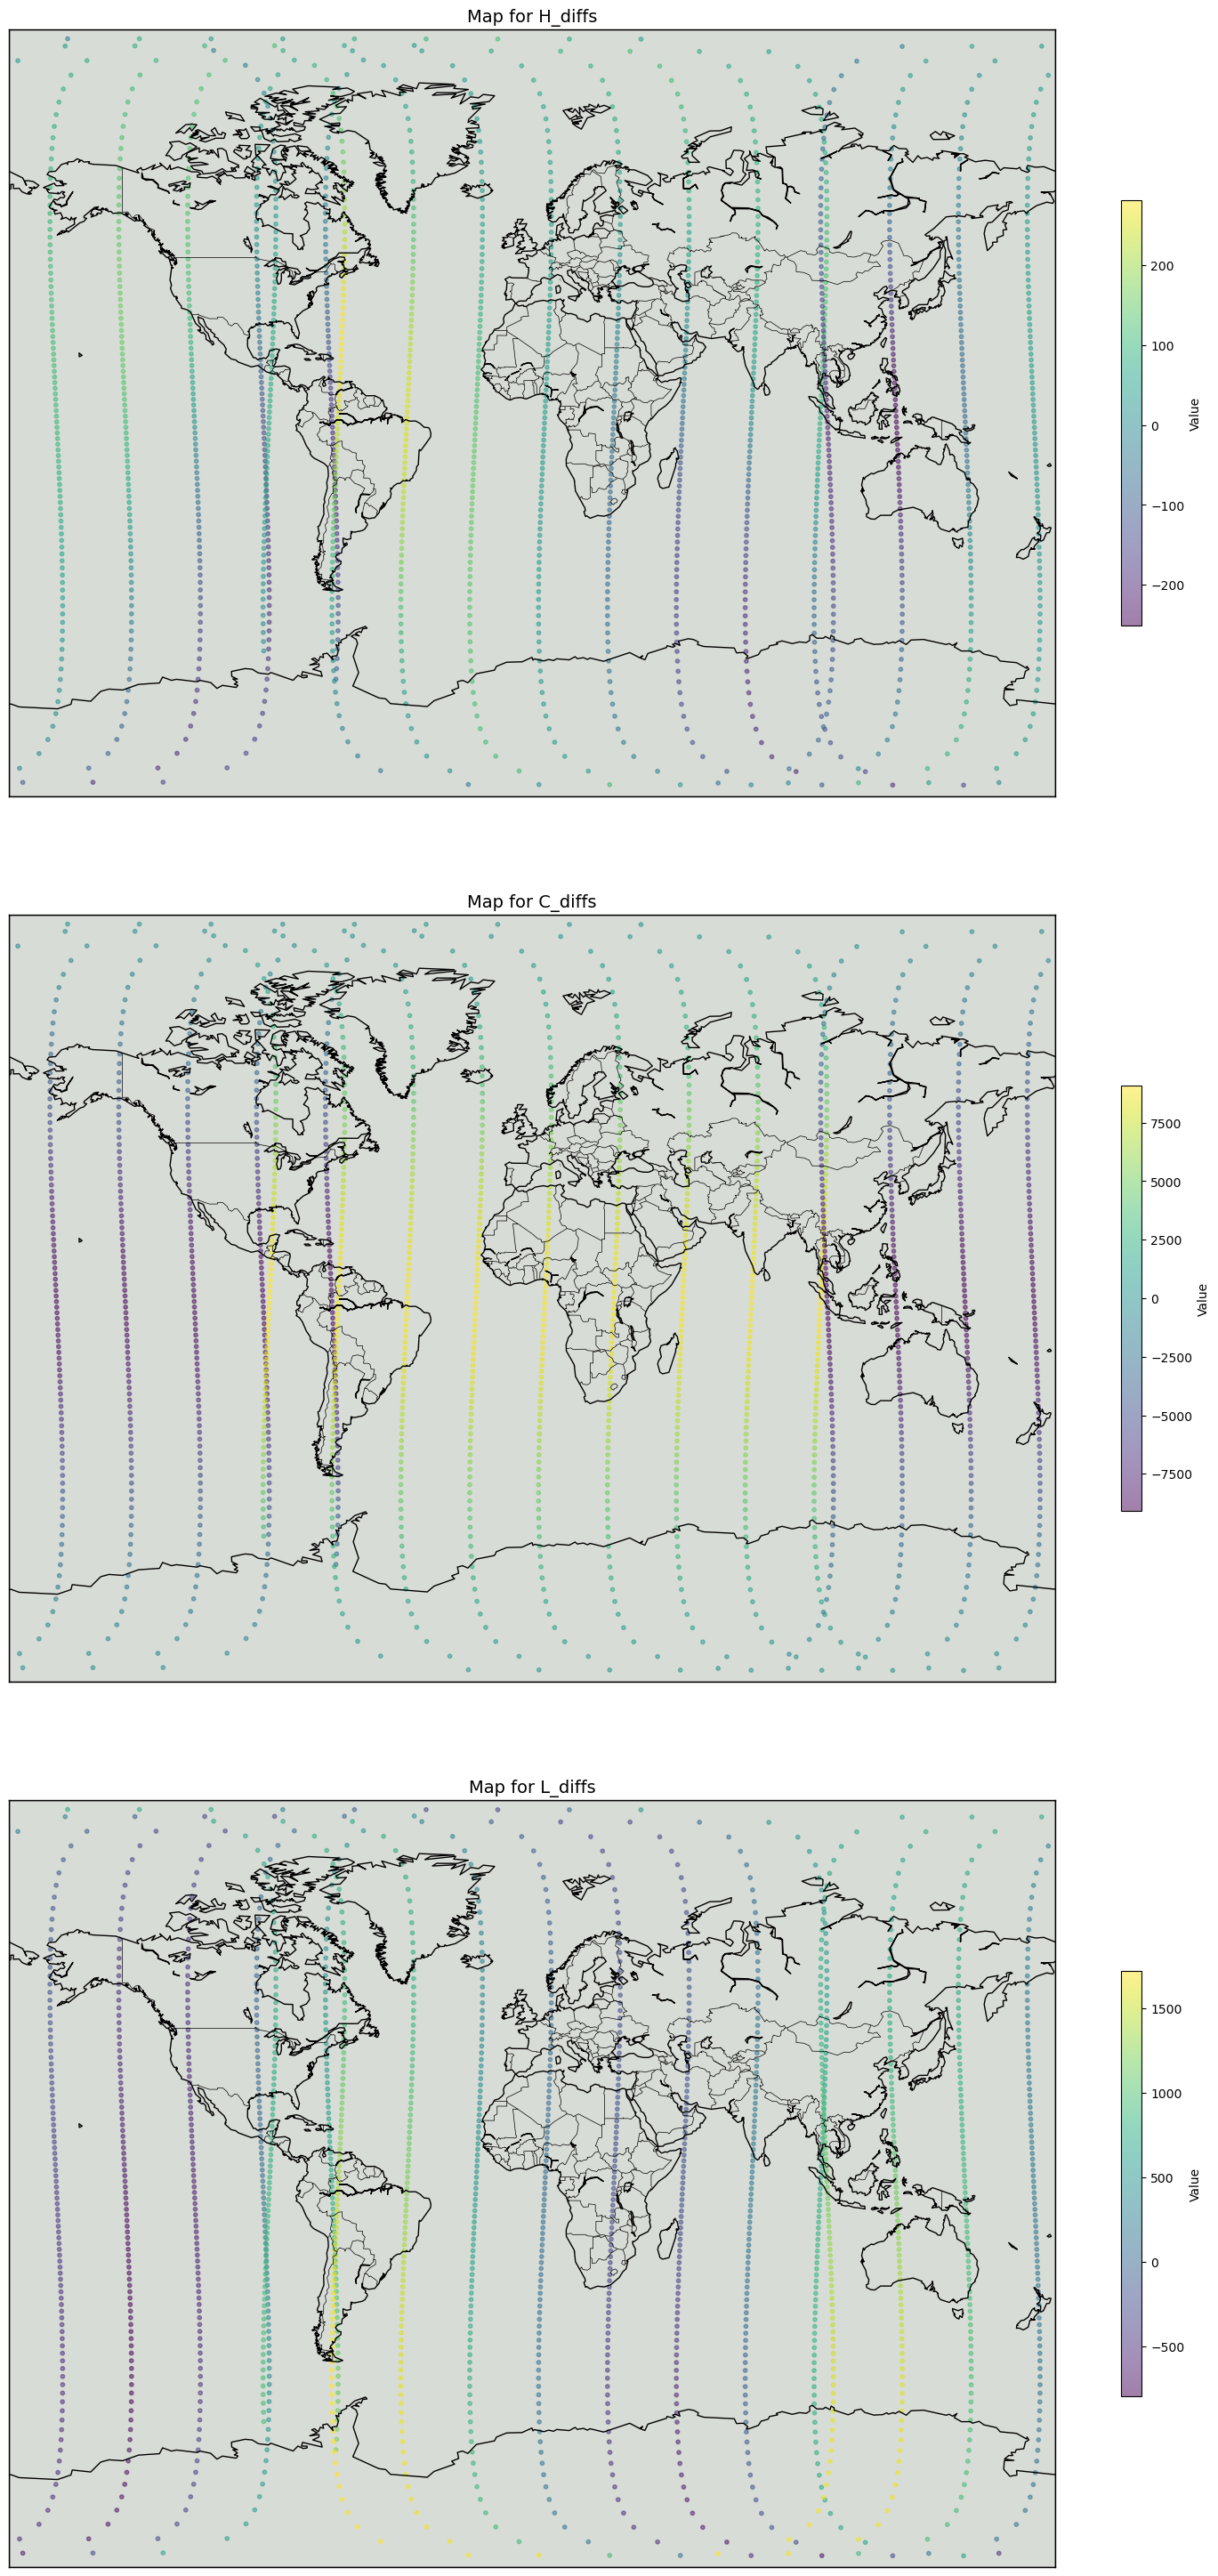

In [270]:
from typing import List, Tuple, Union
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, GCRS, ITRS
from astropy.time import Time
import astropy.units as u

import datetime
from typing import Union

def utc_jd_date(day: int, month: int, year: int, hours: int, minutes: int, seconds: int, mjd: bool = False, midnight: bool = False) -> Union[float, int]:
    if midnight:
        # Convert to datetime object (without hours and seconds)
        date = datetime.datetime(year, month, day)
    else:
        # Convert to datetime object (with hours and seconds)
        date = datetime.datetime(year, month, day, hours, minutes, seconds)

    # Calculate MJD
    mjd_value = (date - datetime.datetime(1858, 11, 17)).total_seconds() / 86400.0
    if mjd:
        return mjd_value
    else:
        # Convert to JD
        jd = mjd_value + 2400000.5
        return jd
    
def eci2ecef_astropy(eci_pos: np.ndarray, eci_vel: np.ndarray, mjd: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert ECI (Earth-Centered Inertial) coordinates to ECEF (Earth-Centered, Earth-Fixed) coordinates using Astropy.

    Parameters
    ----------
    eci_pos : np.ndarray
        ECI position vectors.
    eci_vel : np.ndarray
        ECI velocity vectors.
    mjd : float
        Modified Julian Date.

    Returns
    -------
    tuple
        ECEF position vectors and ECEF velocity vectors.
    """
    # Convert MJD to isot format for Astropy
    time_utc = Time(mjd, format="mjd", scale='utc')

    # Convert ECI position and velocity to ECEF coordinates using Astropy
    eci_cartesian = CartesianRepresentation(eci_pos.T * u.km)
    eci_velocity = CartesianDifferential(eci_vel.T * u.km / u.s)
    gcrs_coords = GCRS(eci_cartesian.with_differentials(eci_velocity), obstime=time_utc)
    itrs_coords = gcrs_coords.transform_to(ITRS(obstime=time_utc))

    # Get ECEF position and velocity from Astropy coordinates
    ecef_pos = np.column_stack((itrs_coords.x.value, itrs_coords.y.value, itrs_coords.z.value))
    ecef_vel = np.column_stack((itrs_coords.v_x.value, itrs_coords.v_y.value, itrs_coords.v_z.value))

    return ecef_pos, ecef_vel

# Instantiate the Transformer for ECEF to LLA conversion
transformer = Transformer.from_crs(
    "EPSG:4978", # WGS-84 (ECEF)
    "EPSG:4326", # WGS-84 (LLA)
    always_xy=True
)

time, H_diffs, C_diffs, L_diffs, positions, velocity = grace1_ephemeris[0], grace1_ephemeris[1], grace1_ephemeris[2], grace1_ephemeris[3], grace1_ephemeris[4], grace1_ephemeris[6]


# Initialize lists for latitudes and longitudes
lats, lons = [], []

# Convert ECI positions to ECEF, then to latitude and longitude
for i, position in enumerate(positions):
    # Convert the time to MJD format
    mjd = utc_jd_date(time[i].day, time[i].month, time[i].year, time[i].hour, time[i].minute, time[i].second, mjd=True)

    # Assuming zero velocity for the conversion, update if you have velocity data
    ecef_pos, _ = eci2ecef_astropy(np.array([position]), np.array([velocity[i]]), mjd)
    
    # Ensure ecef_pos is a single vector of length 3
    ecef_pos = ecef_pos.flatten()  # Flatten the array to 1D if it's not already

    # Transform ECEF to lat/lon
    lat, lon, _ = transformer.transform(ecef_pos[0], ecef_pos[1], ecef_pos[2])
    lats.append(lat)
    lons.append(lon)

# Prepare the Basemap for each dataset
fig, axes = plt.subplots(3, 1, figsize=(15, 30))

# Dataset names for titles and legends
datasets = ['H_diffs', 'C_diffs', 'L_diffs']

# Plotting H_diffs, C_diffs, and L_diffs on separate maps
for i, (diffs, dataset_name) in enumerate(zip([H_diffs, C_diffs, L_diffs], datasets)):
    m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c', ax=axes[i])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='xkcd:light grey')

    # Scatter plot
    xpt, ypt = m(lats, lons)
    scatter_plot = m.scatter(xpt, ypt, c=diffs, alpha=0.5, s=10)

    # Adding title and legend
    axes[i].set_title(f'Map for {dataset_name}', fontsize=14)
    plt.colorbar(scatter_plot, ax=axes[i], orientation='vertical', shrink=0.5, label='Value')

plt.tight_layout()
plt.show()

In [271]:
grace1_ephemeris[5]

[array([7166.9284698893325, 1406.0849353481972, 2142.3573941566297]),
 array([7092.5970437267115, 1396.1262259546832, 2383.764917154452 ]),
 array([7010.440794216255, 1384.628113271016, 2622.583765839622]),
 array([6920.5465140416445, 1371.602577792405 , 2858.5513919468735]),
 array([6823.009414982929 , 1357.063255964883 , 3091.4080218340423]),
 array([6717.933057982772 , 1341.0254316114947, 3320.8969304142406]),
 array([6605.429275195862 , 1323.5060258241522, 3546.7647152091126]),
 array([6485.618083768909 , 1304.5235852788896, 3768.7615703326605]),
 array([6358.627591097558, 1284.098268920085, 3986.641560186208]),
 array([6224.593891311929, 1262.251832956064, 4200.162892605953]),
 array([6083.660952743633 , 1239.0076141251743, 4409.088191172884 ]),
 array([5935.980496143509 , 1214.3905111712108, 4613.18476635684  ]),
 array([5781.711863427236, 1188.42696448529 , 4812.224885135476]),
 array([5621.021876747982 , 1161.1449338700434, 5005.986038690431 ]),
 array([5454.084687713154 , 1132

# Applying the corrections
In the final versions, this will be through the lat/lon look up, but for now we can just do it on the sp3 time. 

In [273]:
from datetime import datetime, timedelta

# run the code above with grace 2 data
with open(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'grace-fo-2-tle-43477.json'), "r") as file:
    grace2_tle_raw = json.load(file)

# then compare the difference to the sp3 data of grace 1 tle to see if we can reduce the errors in the hcl
grace2_tles = [entry for entry in grace2_tle_raw if start_time_range <= datetime.fromisoformat(entry['EPOCH']).replace(tzinfo=tzutc()) <= end_time_range]
grace2_tle_ephemeris = tle_propagate_using_sp3_time(grace2_tles, sp3_time)

# if the datetime is the same, then apply the xyz_corection to the grace 2 tle data
def apply_correction(grace1_corrections, grace2_tle_ephemeris):
    count = 0
    for i in range(0, len(grace1_corrections[0]), 1):
        for j in range(0, len(grace2_tle_ephemeris), 1):
            if grace1_corrections[0][i] == grace2_tle_ephemeris[j]['time']:
                grace2_tle_ephemeris[j]['corrected_position'] = grace2_tle_ephemeris[j]['position'] - grace1_corrections[6][i]
                count += 1
                break
    print('Corrections applied: ', count)
    return grace2_tle_ephemeris

grace2_tle_corrected_ephemeris = apply_correction(grace1_ephemeris, grace2_tle_ephemeris) # grace1 ephemeris has the corrections

# now take the new data and then do a HCL analysis between the new data and the sp3 data
product_grace2 = sp3.Product.from_file(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'GFZOP_RSO_L65_G_20230105_220000_20230106_120000_v02.sp3.sp3'))
start_time = product.satellites[0].records[0].time
end_time = product.satellites[0].records[-1].time
start_time_range = start_time - timedelta(days=1) # need some buffer room
end_time_range = start_time + timedelta(days=2)
grace2_sp3_ephemeris = process_raw_sp3(product_grace2)

# Calculate altitudes and extract times
tle_times = [entry['time'] for entry in grace2_tle_corrected_ephemeris]
grace2_sp3 = [np.linalg.norm(entry['position']) for entry in grace2_sp3_ephemeris]
grace2_tle = [np.linalg.norm(entry['position']) for entry in grace2_tle_ephemeris]
grace2_tle_corrected = [np.linalg.norm(entry['corrected_position']) for entry in grace2_tle_corrected_ephemeris]

# plot difference between grace2_tle and sp3
grace2_tle_sp3_diff = []
for i in range(0, len(grace2_tle), 1):
    grace2_tle_sp3_diff.append(grace2_tle[i] - grace2_sp3[i])

# plot difference between grace2_tle_corrected and sp3
grace2_tle_corrected_sp3_diff = []
for i in range(0, len(grace2_tle_corrected), 1):
    grace2_tle_corrected_sp3_diff.append(grace2_tle_corrected[i] - grace2_sp3[i])

# Plot using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(tle_times, grace2_tle_sp3_diff, linestyle='-', color='blue', label='DIFF TLE - SP3')
plt.plot(tle_times, grace2_tle_corrected_sp3_diff, linestyle='-', color='red', label='DIFF TLE Corrected - SP3')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # for slanting date labels
plt.title("Difference Between TLE and SP3 Altitudes")
plt.xlabel("UTC Time")
plt.ylabel("Altitude Difference (m)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# if the datetime is the same, then apply the xyz_corection to the grace 2 tle data
def apply_correction(grace1_corrections, grace2_tle_ephemeris):
    count = 0
    for i in range(0, len(grace1_corrections[0]), 1):
        for j in range(0, len(grace2_tle_ephemeris), 1):
            if grace1_corrections[0][i] == grace2_tle_ephemeris[j]['time']:
                grace2_tle_ephemeris[j]['corrected_position'] = grace2_tle_ephemeris[j]['position'] - grace1_corrections[5][i]
                count += 1
                break
    print('Corrections applied: ', count)
    return grace2_tle_ephemeris

grace2_tle_corrected_ephemeris = apply_correction(grace1_ephemeris, grace2_tle_ephemeris)

Corrections applied:  1682


In [ ]:
# create a plotly to see the corection data
# Calculate altitudes and extract times
tle_times = [entry['time'] for entry in sp3_ephemeris]
grace2_sp3 = [np.linalg.norm(entry['position']) for entry in grace2_sp3_ephemeris]
grace2_tle = [np.linalg.norm(entry['position']) for entry in grace2_tle_ephemeris]
grace2_tle_corrected = [np.linalg.norm(entry['corrected_position']) for entry in grace2_tle_corrected_ephemeris]
grace1_tle = [np.linalg.norm(entry['position']) for entry in tle_ephemeris]
grace1_sp3 = [np.linalg.norm(entry['position']) for entry in sp3_ephemeris]

# Plot
import plotly.graph_objects as go
fig = go.Figure()

# Add SP3 altitude data
fig.add_trace(go.Scatter(x=tle_times, y=grace2_sp3, mode='lines+markers',
                         name='G2 SP3', line=dict(color='blue')))

#Add TLE altitude data
fig.add_trace(go.Scatter(x=tle_times, y=grace2_tle, mode='lines+markers',
                         name='G2 TLE', line=dict(color='red')))

# Add TLE corrected data
fig.add_trace(go.Scatter(x=tle_times, y=grace2_tle_corrected, mode='lines+markers',
                         name='G2 TLE Corrected', line=dict(color='green')))

# Add GRACE 1 TLE corrected data
fig.add_trace(go.Scatter(x=tle_times, y=grace1_tle, mode='lines+markers',
                         name='G1 TLE', line=dict(color='pink')))

fig.add_trace(go.Scatter(x=tle_times, y=grace1_sp3, mode='lines+markers',
                         name='G1 SP3 ', line=dict(color='purple')))

# Add vertical lines for start_time and end_time
fig.add_shape(
    go.layout.Shape(type="line", x0=start_time, x1=start_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="Start Time")
)
fig.add_shape(
    go.layout.Shape(type="line", x0=end_time, x1=end_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="End Time")
)

# Setting labels, title and layout
fig.update_layout(title='Altitude over Time',
                  xaxis_title='Time',
                  yaxis_title='Altitude (m)',
                  xaxis=dict(showgrid=True, showline=True, showticklabels=True, tickangle=45),
                  yaxis=dict(showgrid=True, showline=True, showticklabels=True),
                  showlegend=True)

# Show the interactive plot
fig.show()

In [ ]:
# Calculate altitudes and extract times
tle_times = [entry['time'] for entry in grace2_tle_corrected_ephemeris]
grace2_sp3 = [np.linalg.norm(entry['position']) for entry in grace2_sp3_ephemeris]
grace2_tle = [np.linalg.norm(entry['position']) for entry in grace2_tle_ephemeris]
grace2_tle_corrected = [np.linalg.norm(entry['corrected_position']) for entry in grace2_tle_corrected_ephemeris]

# plot difference between grace2_tle and sp3
grace2_tle_sp3_diff = []
for i in range(0, len(grace2_tle), 1):
    grace2_tle_sp3_diff.append(grace2_tle[i] - grace2_sp3[i])

# plot difference between grace2_tle_corrected and sp3
grace2_tle_corrected_sp3_diff = []
for i in range(0, len(grace2_tle_corrected), 1):
    grace2_tle_corrected_sp3_diff.append(grace2_tle_corrected[i] - grace2_sp3[i])

# Plot using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(tle_times, grace2_tle_sp3_diff, linestyle='-', color='blue', label='DIFF TLE - SP3')
plt.plot(tle_times, grace2_tle_corrected_sp3_diff, linestyle='-', color='red', label='DIFF TLE Corrected - SP3')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # for slanting date labels
plt.title("Difference Between TLE and SP3 Altitudes")
plt.xlabel("UTC Time")
plt.ylabel("Altitude Difference (m)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Apply the lat lng corrections

In [ ]:
import datetime
for item in grace2_tle_ephemeris:
    # Convert the time to MJD format
    mjd = utc_jd_date(item['time'].day, item['time'].month, item['time'].year, item['time'].hour, item['time'].minute, item['time'].second, mjd=True)
    # mjd = utc_jd_date(time[i].day, time[i].month, time[i].year, time[i].hour, time[i].minute, time[i].second, mjd=True)

    # Assuming zero velocity for the conversion, update if you have velocity data
    ecef_pos, _ = eci2ecef_astropy(np.array([item['position']]), np.array([item['velocity']]), mjd)
    # ecef_pos, _ = eci2ecef_astropy(np.array([position]), np.array([velocity[i]]), mjd)
    
    # Ensure ecef_pos is a single vector of length 3
    ecef_pos = ecef_pos.flatten()  # Flatten the array to 1D if it's not already

    # Transform ECEF to lat/lon
    lat, lon, _ = transformer.transform(ecef_pos[0], ecef_pos[1], ecef_pos[2])
    item['lat'] = lat
    item['lon'] = lon


In [ ]:
grace2_tle_ephemeris[0]

{'time': datetime.datetime(2023, 10, 26, 21, 59, 42, tzinfo=datetime.timezone.utc),
 'position': array([ 3201485.024715307, -1650618.102256936,  5843392.857269769]),
 'velocity': array([-5635.414495189641 ,  3213.7953821314804,  3987.6999820605783]),
 'corrected_position': array([ 3199611.0179747804, -1654891.0872488255,  5843143.649809646 ]),
 'lat': -32.01340449716146,
 'lon': 58.62447252342195}

0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


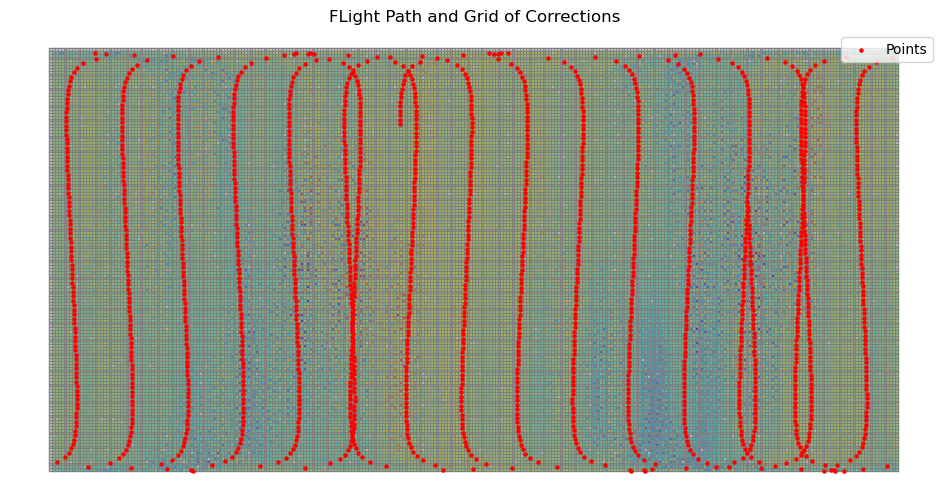

In [ ]:
# import the grid_cells at grid_cells.geojson
import geopandas as gpd
from shapely.geometry import Point

grid_cells = gpd.read_file('grid_cells2.geojson')

# Create a GeoDataFrame for grid cells
grid_gdf = gpd.GeoDataFrame(grid_cells, crs='EPSG:4326')

# Loop through the grace2_tle_ephemeris and see which grid cell it is in, then add the H_diffs, C_diffs, L_diffs to the grace2_tle_ephemeris item
count = 0
pnts = []
for item in grace2_tle_ephemeris:
    pnt = Point(item['lat'], item['lon'])
    pnts.append(pnt)
    # Query the grid GeoDataFrame for points within cells
    query = grid_gdf.contains(pnt)
    if query.any():
        # Get the index of the cell containing the point
        cell_index = query.idxmax()
        # Extract values from the cell and add them to the grace2_tle_ephemeris item
        item['H_diffs_mean'] = grid_gdf.at[cell_index, 'mean_H_diffs']
    else: 
        item['H_diffs_mean'] = None
        count += 1

print(count)
# Plot the grid cells
ax = grid_cells.plot(markersize=.1, figsize=(12, 8), column='mean_H_diffs', cmap='jet')
plt.autoscale(False)
grid_cells.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")
ax.legend()

# Plot all the points from the 'pnts' list
x_coords = [pnt.x for pnt in pnts]
y_coords = [pnt.y for pnt in pnts]
plt.scatter(x_coords, y_coords, color='red', s=5, label='Points')

# Show the legend
plt.legend()
# add title
plt.title('FLight Path and Grid of Corrections')
plt.show()

In [ ]:
import numpy as np

for item in grace2_tle_ephemeris:
    # Calculate the new position as the Euclidean norm of 'position' minus 'H_diffs_mean'
    if item['H_diffs_mean'] is not None:
        item['new_position'] = np.linalg.norm(item['position']) - item['H_diffs_mean']
    else:
        item['new_position'] = np.linalg.norm(item['position'])

In [ ]:
# create a histogram of the H_diffs_mean
import matplotlib.pyplot as plt
plt.hist([item['H_diffs_mean'] for item in grace2_tle_ephemeris if item['H_diffs_mean'] is not None], bins=100)
plt.xlabel('H_diffs_mean')
plt.ylabel('Frequency')
plt.title('Distribution of Altitude Corrections')
plt.show()

In [ ]:
# so we need to first take the tle positions and then apply the corrections to it, we can start only with alt
tle_times = [entry['time'] for entry in grace2_tle_ephemeris]
grace2_tle = [np.linalg.norm(entry['position']) for entry in grace2_tle_ephemeris]
grace2_tle_corrected = [np.linalg.norm(entry['corrected_position']) for entry in grace2_tle_ephemeris]
grace2_sp3 = [np.linalg.norm(entry['position']) for entry in grace2_sp3_ephemeris]
grace2_tle_corrected_mean = [np.linalg.norm(entry['new_position']) for entry in grace2_tle_ephemeris]

# Plot
import plotly.graph_objects as go
fig = go.Figure()

#Add TLE altitude data
fig.add_trace(go.Scatter(x=tle_times, y=grace2_tle, mode='lines+markers',
                         name='G2 TLE', line=dict(color='red')))

# Add TLE corrected data
fig.add_trace(go.Scatter(x=tle_times, y=grace2_tle_corrected, mode='lines+markers',
                         name='G2 TLE Corrected', line=dict(color='green')))

# Add SP3 altitude data
fig.add_trace(go.Scatter(x=tle_times, y=grace2_sp3, mode='lines+markers',
                         name='G2 SP3', line=dict(color='blue')))

# Add TLE corrected mean data
fig.add_trace(go.Scatter(x=tle_times, y=grace2_tle_corrected_mean, mode='lines+markers',
                            name='G2 TLE Corrected Mean', line=dict(color='purple')))

# Add vertical lines for start_time and end_time
fig.add_shape(
    go.layout.Shape(type="line", x0=start_time, x1=start_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="Start Time")
)
fig.add_shape(
    go.layout.Shape(type="line", x0=end_time, x1=end_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="End Time")
)

# Setting labels, title and layout
fig.update_layout(title='Altitude over Time',
                  xaxis_title='Time',
                  yaxis_title='Altitude (m)',
                  xaxis=dict(showgrid=True, showline=True, showticklabels=True, tickangle=45),
                  yaxis=dict(showgrid=True, showline=True, showticklabels=True),
                  showlegend=True)

# Show the interactive plot
fig.show()


In [ ]:
# Calculate altitudes and extract times
tle_times = [entry['time'] for entry in grace2_tle_corrected_ephemeris]
grace2_sp3 = [np.linalg.norm(entry['position']) for entry in grace2_sp3_ephemeris]
grace2_tle = [np.linalg.norm(entry['position']) for entry in grace2_tle_ephemeris]
grace2_tle_corrected = [np.linalg.norm(entry['corrected_position']) for entry in grace2_tle_corrected_ephemeris]
grace2_tle_corrected_mean = [np.linalg.norm(entry['new_position']) for entry in grace2_tle_ephemeris]

# plot difference between grace2_tle and sp3
grace2_tle_sp3_diff = []
for i in range(0, len(grace2_tle), 1):
    grace2_tle_sp3_diff.append(grace2_tle[i] - grace2_sp3[i])

# plot difference between grace2_tle_corrected and sp3
grace2_tle_corrected_sp3_diff = []
for i in range(0, len(grace2_tle_corrected), 1):
    grace2_tle_corrected_sp3_diff.append(grace2_tle_corrected[i] - grace2_sp3[i])

# plot difference between grace2_tle_corrected_mean and sp3
grace2_tle_corrected_mean_sp3_diff = []
for i in range(0, len(grace2_tle_corrected_mean), 1):
    grace2_tle_corrected_mean_sp3_diff.append(grace2_tle_corrected_mean[i] - grace2_sp3[i])

# Plot using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(tle_times, grace2_tle_sp3_diff, linestyle='-', color='blue', label='DIFF TLE - SP3')
plt.plot(tle_times, grace2_tle_corrected_sp3_diff, linestyle='-', color='red', label='DIFF TLE Corrected - SP3')
plt.plot(tle_times, grace2_tle_corrected_mean_sp3_diff, linestyle='-', color='green', label='DIFF TLE Corrected Mean - SP3')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # for slanting date labels
plt.title("Difference Between TLE and SP3 Altitudes")
plt.xlabel("UTC Time")
plt.ylabel("Altitude Difference (m)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()
plt.show()

# smooth this time series